# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

# <font color='blue'>Index</font>
- <font color='blue'>1. Initial Steps</font>
	- <font color='blue'>1.1 Imports</font>
	- <font color='blue'>1.2 Random Seeds</font>
	- <font color='blue'>1.3 Google Drive Connect</font>
	- <font color='blue'>1.4 Setting Paths</font>
	- <font color='blue'>1.5 Defining Generator</font>
	- <font color='blue'>1.6 Listing File Counts</font>
- <font color='blue'>2. Models</font>
	- <font color='blue'>2.1 Model 1 - </font>
		- <font color='blue'>2.1.1 Design, Compile & Summary</font>
		- <font color='blue'>2.1.2 Model Training</font>
		- <font color='blue'>2.1.3 Accuracy & Remarks</font>
		- <font color='blue'>2.1.4 Next Actions</font>
	- <font color='blue'>2.2 Model 2 - </font>
		- <font color='blue'>2.2.1 Design, Compile & Summary</font>
		- <font color='blue'>2.2.2 Model Training</font>
		- <font color='blue'>2.2.3 Accuracy & Remarks</font>
		- <font color='blue'>2.2.4 Next Actions</font>
	- <font color='blue'>2.3 Model 3 - </font>
		- <font color='blue'>2.3.1 Design, Compile & Summary</font>
		- <font color='blue'>2.3.2 Model Training</font>
		- <font color='blue'>2.3.3 Accuracy & Remarks</font>
		- <font color='blue'>2.3.4 Next Actions</font>
	- <font color='blue'>2.4 Model 4 - </font>
		- <font color='blue'>2.4.1 Design, Compile & Summary</font>
		- <font color='blue'>2.4.2 Model Training</font>
		- <font color='blue'>2.4.3 Accuracy & Remarks</font>
		- <font color='blue'>2.4.4 Next Actions</font>
	- <font color='blue'>2.5 Model 5 - </font>
		- <font color='blue'>2.5.1 Design, Compile & Summary</font>
		- <font color='blue'>2.5.2 Model Training</font>
		- <font color='blue'>2.5.3 Accuracy & Remarks</font>
		- <font color='blue'>2.5.4 Next Actions</font>
	- <font color='blue'>2.6 Model 6 - </font>
		- <font color='blue'>2.6.1 Design, Compile & Summary</font>
		- <font color='blue'>2.6.2 Model Training</font>
		- <font color='blue'>2.6.3 Accuracy & Remarks</font>
		- <font color='blue'>2.6.4 Next Actions</font>
- <font color='blue'>3. Conclusion & Final Selection</font>

## <font color='blue'>1. Initial Steps</font>

### <font color='blue'>1.1 Imports</font>

In [10]:
import numpy as np
import os
import imageio.v2 as imageio
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.applications import mobilenet

### <font color='blue'>1.2 Random Seeds</font>

We set the random seed so that the results don't vary drastically.

In [11]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from google.colab import drive
drive.mount('/content/gdrive')In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

### <font color='blue'>1.3 Google Drive Connect</font>

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

### <font color='blue'>1.4 Setting Paths</font>

In [13]:
train_doc = np.random.permutation(open('/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/val.csv').readlines())

# train_doc = np.random.permutation(open('G:\\My Drive\\Personal\\upGrad\\MS\\Recurrent Neural Networks\\Project_data\\train.csv').readlines())
# val_doc = np.random.permutation(open('G:\\My Drive\\Personal\\upGrad\\MS\\Recurrent Neural Networks\\Project_data\\val.csv').readlines())

batch_size = 64 #experiment with the batch size 16, 32, 64

### <font color='blue'>1.5 Defining Generator</font>

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [14]:
def generator(source_path, folder_list, batch_size, img_idx, image_height, image_width):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # img_idx = [1,4,7,10,13,16,19,22,25,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        # left over batches which should be handled separately
        leftover_batches = len(t) - num_batches * batch_size

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image, (image_height, image_width))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 104
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 117
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 123

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        # write the code for the remaining data points which are left after full batches
        if leftover_batches != 0:
            for batch in range(num_batches):
                # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((batch_size,len(img_idx),image_height, image_width,3))
                # batch_labels is the one hot representation of the output: 10 videos with 5 columns as classes
                batch_labels = np.zeros((batch_size,5))
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path +'/'+t[batch * batch_size + folder].split(';')[0])
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in

                        image = imageio.imread(source_path +'/'+t[batch * batch_size + folder].split(';')[0] +'/'+imgs[item]).astype(np.float32)
                        image = resize(image, (image_height,image_width))

                        batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 104
                        batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 117
                        batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 123

                    #Fill the one hot encoding stuff where we maintain the label
                    batch_labels[folder, int(t[batch * batch_size + folder].split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

### <font color='blue'>1.6 Listing File Counts</font>

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train'
val_path = '/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/val'
model_path_prefix = '/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Models/'
# train_path = 'G:\\My Drive\\Personal\\upGrad\\MS\\Recurrent Neural Networks\\Project_data\\train'
# val_path = 'G:\\My Drive\\Personal\\upGrad\\MS\\Recurrent Neural Networks\\Project_data\\val'
# model_path_prefix = 'C:\\Temp\\RNN\\'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [16]:
img_idx = list(range(1,30,3))
image_height = 50
image_width = 50
batch_size = 1
test_gen = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width)
d = next(test_gen)[0]

Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\train ; batch size = 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


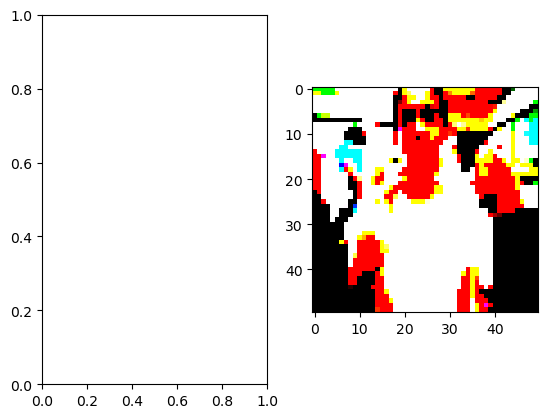

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.imshow(d[0,9,:,:,:])
# axes[1].imshow(d[3,15,:,:,:])

## <font color='blue'>2. Models</font>

### <font color='blue'>2.1 Model 1 - </font>

#### <font color='blue'>2.1.1 Design, Compile & Summary</font>

In [18]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
image_height = 50
image_width = 50
batch_size = 1
num_classes = 5

model = Sequential()

model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(frames, image_height, image_width, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 50, 50, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3  (None, 5, 25, 25, 16)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 5, 25, 25, 16)     64        
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 25, 25, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 12, 12, 32)     0         
 g3D)                                                            
                                                    

#### <font color='blue'>2.1.2 Model Training</font>

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_path_prefix + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\train ; batch size = 1


C:\Users\ASyed\AppData\Local\Temp\ipykernel_46732\4257311695.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15




663/663 [==============================] - ETA: 0s - loss: 1.8976 - categorical_accuracy: 0.3952Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 1

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00001-1.89764-0.39517-2.16167-0.49000.h5
663/663 [==============================] - 254s 376ms/step - loss: 1.8976 - categorical_accuracy: 0.3952 - val_loss: 2.1617 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 2/15
  1/663 [..............................] - ETA: 12s - loss: 1.2494 - categorical_accuracy: 0.0000e+00

c:\Users\ASyed\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


663/663 [==============================] - ETA: 0s - loss: 1.0559 - categorical_accuracy: 0.5958
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00002-1.05591-0.59578-1.08228-0.67000.h5
663/663 [==============================] - 197s 297ms/step - loss: 1.0559 - categorical_accuracy: 0.5958 - val_loss: 1.0823 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/15
663/663 [==============================] - ETA: 0s - loss: 0.6762 - categorical_accuracy: 0.7602
Epoch 3: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00003-0.67621-0.76018-0.92267-0.74000.h5
663/663 [==============================] - 193s 292ms/step - loss: 0.6762 - categorical_accuracy: 0.7602 - val_loss: 0.9227 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 4/15
663/663 [==============================] - ETA: 0s - loss: 0.4351 - categorical_accuracy: 0.8296
Epoch 4: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00004-0.43515-0.82956

#### <font color='blue'>2.1.3 Accuracy & Remarks</font>

<b>Accuracy</b>:
- Training: 1.0
- Validation: 0.86

<b>Remarks:</b>
- Started with batch size 1 to check the model is working 
- Validation accuracy is not bad
- High difference between Training vs Validation, shows model to be overfitting

#### <font color='blue'>2.1.4 Next Actions</font>

- Increase Batch Size
- Increase Image Height and Width


### <font color='blue'>2.2 Model 2 - </font>

#### <font color='blue'>2.2.1 Design, Compile & Summary</font>

In [22]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
image_height = 100
image_width = 100
batch_size = 32
num_classes = 5

model = Sequential()

model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(frames, image_height, image_width, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 10, 100, 100, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 5, 50, 50, 16)     0         
 g3D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 5, 50, 50, 16)     64        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 2, 25, 25, 32)     0         
 g3D)                                                 

#### <font color='blue'>2.2.2 Model Training</font>

In [23]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_path_prefix + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\train ; batch size = 32


C:\Users\ASyed\AppData\Local\Temp\ipykernel_46732\842919994.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.4074 - categorical_accuracy: 0.5521Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 32

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00001-1.40741-0.55208-31.82745-0.27344.h5
21/21 [==============================] - 158s 8s/step - loss: 1.4074 - categorical_accuracy: 0.5521 - val_loss: 31.8275 - val_categorical_accuracy: 0.2734 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.5045 - categorical_accuracy: 0.8259
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00002-0.50449-0.82589-22.73162-0.36719.h5
21/21 [==============================] - 160s 8s/step - loss: 0.5045 - categorical_accuracy: 0.8259 - val_loss: 22.7316 - val_categorical_accuracy: 0.3672 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.1814 - categorical_accuracy: 0.

#### <font color='blue'>2.2.3 Accuracy & Remarks</font>

<b>Accuracy</b>:
- Training: 1.0
- Validation: 0.89

<b>Remarks:</b>
- Increased batch size + Image size, might have degraded performance
- Validation Accuracy has increased
- Training accuracy at 100% and High difference between Training vs Validation, shows model to be overfitting

#### <font color='blue'>2.2.4 Next Actions</font>

Introduced Dropout with 0.5

### <font color='blue'>2.3 Model 3 - </font>

#### <font color='blue'>2.3.1 Design, Compile & Summary</font>

In [24]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
image_height = 100
image_width = 100
batch_size = 32
num_classes = 5

model = Sequential()

model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(frames, image_height, image_width, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 10, 100, 100, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 5, 50, 50, 16)     0         
 g3D)                                                            
                                                                 
 dropout (Dropout)           (None, 5, 50, 50, 16)     0         
                                                                 
 batch_normalization_9 (Bat  (None, 5, 50, 50, 16)     64        
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 5, 50, 50, 32)     13856     
                                                      

#### <font color='blue'>2.3.2 Model Training</font>

In [25]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_path_prefix + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\train ; batch size = 32


C:\Users\ASyed\AppData\Local\Temp\ipykernel_46732\842919994.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.0307 - categorical_accuracy: 0.3423Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 32

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00001-2.03073-0.34226-8.60648-0.29688.h5
21/21 [==============================] - 193s 9s/step - loss: 2.0307 - categorical_accuracy: 0.3423 - val_loss: 8.6065 - val_categorical_accuracy: 0.2969 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.4042 - categorical_accuracy: 0.4554
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00002-1.40424-0.45536-4.19344-0.27344.h5
21/21 [==============================] - 186s 9s/step - loss: 1.4042 - categorical_accuracy: 0.4554 - val_loss: 4.1934 - val_categorical_accuracy: 0.2734 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.1220 - categorical_accuracy: 0.5580

#### <font color='blue'>2.3.3 Accuracy & Remarks</font>

<b>Accuracy</b>:
- Training: 0.65
- Validation: 0.77

<b>Remarks:</b>
- Suffered in both Training and Validation Accuracy
- Training accuracy is more than Validation, issue in the learning itself

#### <font color='blue'>2.3.4 Next Actions</font>

Change architecture starting with 32 layers

### <font color='blue'>2.4 Model 4 - </font>

#### <font color='blue'>2.4.1 Design, Compile & Summary</font>

In [28]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
image_height = 100
image_width = 100
batch_size = 64
num_classes = 5

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(frames, image_height, image_width, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 100, 100, 32   2624      
                             )                                   
                                                                 
 max_pooling3d_15 (MaxPooli  (None, 5, 50, 50, 32)     0         
 ng3D)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 5, 50, 50, 32)     0         
                                                                 
 batch_normalization_15 (Ba  (None, 5, 50, 50, 32)     128       
 tchNormalization)                                               
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 50, 50, 64)     55360     
                                                      

#### <font color='blue'>2.4.2 Model Training</font>

In [29]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_path_prefix + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\train ; batch size = 64


C:\Users\ASyed\AppData\Local\Temp\ipykernel_46732\3720141927.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 2.1899 - categorical_accuracy: 0.3466 Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 64

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00001-2.18986-0.34659-40.54904-0.26562.h5
11/11 [==============================] - 301s 30s/step - loss: 2.1899 - categorical_accuracy: 0.3466 - val_loss: 40.5490 - val_categorical_accuracy: 0.2656 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.4236 - categorical_accuracy: 0.4986 
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00002-1.42362-0.49858-40.92770-0.23438.h5
11/11 [==============================] - 336s 33s/step - loss: 1.4236 - categorical_accuracy: 0.4986 - val_loss: 40.9277 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.0030 - categorical_accuracy

#### <font color='blue'>2.4.3 Accuracy & Remarks</font>

<b>Accuracy</b>:
- Training: 0.89
- Validation: 0.82

<b>Remarks:</b>
- Training and Validation Accuracy increased
- Validation accuracy is not in acceptable range
- High number of trainable params increasing the model size

#### <font color='blue'>2.4.4 Next Actions</font>

- Increase batch size to 64
- Crop image to 50 x 50

### <font color='blue'>2.5 Model 5 - </font>

#### <font color='blue'>2.5.1 Design, Compile & Summary</font>

In [30]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
image_height = 50
image_width = 50
batch_size = 64
num_classes = 5

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(frames, image_height, image_width, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 10, 50, 50, 32)    2624      
                                                                 
 max_pooling3d_18 (MaxPooli  (None, 5, 25, 25, 32)     0         
 ng3D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 5, 25, 25, 32)     0         
                                                                 
 batch_normalization_18 (Ba  (None, 5, 25, 25, 32)     128       
 tchNormalization)                                               
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 25, 25, 64)     55360     
                                                                 
 max_pooling3d_19 (MaxPooli  (None, 2, 12, 12, 64)    

#### <font color='blue'>2.5.2 Model Training</font>

In [31]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_path_prefix + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\train ; batch size = 64


C:\Users\ASyed\AppData\Local\Temp\ipykernel_46732\3720141927.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 2.2656 - categorical_accuracy: 0.3139 Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 64

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00001-2.26564-0.31392-20.95386-0.20312.h5
11/11 [==============================] - 298s 29s/step - loss: 2.2656 - categorical_accuracy: 0.3139 - val_loss: 20.9539 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.6287 - categorical_accuracy: 0.4119 
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00002-1.62866-0.41193-16.19118-0.24219.h5
11/11 [==============================] - 251s 25s/step - loss: 1.6287 - categorical_accuracy: 0.4119 - val_loss: 16.1912 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.4189 - categorical_accuracy

#### <font color='blue'>2.5.3 Accuracy & Remarks</font>

<b>Accuracy</b>:
- Training: 0.79
- Validation: 0.79

<b>Remarks:</b>
- Impacted performance a lot
- Validation accuracy decreased
- Both Training and Valdiation accuracies are in acceptable range and there isnt much difference either

#### <font color='blue'>2.5.4 Next Actions</font>

- Reduce batch size to 32
- Change architecture to start with 8 layers, to reduce size

### <font color='blue'>2.6 Model 6 - </font>

#### <font color='blue'>2.6.1 Design, Compile & Summary</font>

In [32]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
image_height = 50
image_width = 50
batch_size = 32
num_classes = 5

model = Sequential()

model.add(Conv3D(8, (3,3,3), padding='same', input_shape=(frames, image_height, image_width, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(16, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 max_pooling3d_21 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 5, 25, 25, 8)      0         
                                                                 
 batch_normalization_21 (Ba  (None, 5, 25, 25, 8)      32        
 tchNormalization)                                               
                                                                 
 conv3d_22 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 max_pooling3d_22 (MaxPooli  (None, 2, 12, 12, 16)    

#### <font color='blue'>2.6.2 Model Training</font>

In [33]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_height, image_width)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_height, image_width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_path_prefix + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\train ; batch size = 32


C:\Users\ASyed\AppData\Local\Temp\ipykernel_46732\3720141927.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.2661 - categorical_accuracy: 0.2158Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 32

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00001-2.26614-0.21577-3.01016-0.22656.h5
21/21 [==============================] - 254s 12s/step - loss: 2.2661 - categorical_accuracy: 0.2158 - val_loss: 3.0102 - val_categorical_accuracy: 0.2266 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.9355 - categorical_accuracy: 0.2455
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0518_28_54.709195\model-00002-1.93554-0.24554-1.87922-0.24219.h5
21/21 [==============================] - 242s 12s/step - loss: 1.9355 - categorical_accuracy: 0.2455 - val_loss: 1.8792 - val_categorical_accuracy: 0.2422 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.6014 - categorical_accuracy: 0.32

#### <font color='blue'>2.6.3 Accuracy & Remarks</font>

<b>Accuracy</b>:
- Training: 0.38
- Validation: 0.51

<b>Remarks:</b>
- Training and Validation Accuracies are least of all models, not acceptable

#### <font color='blue'>2.6.4 Next Actions</font>

As we already have some good performing models, will choose one from those

## <font color='blue'>3. Conclusion & Final Selection</font>

Selected the best model from Model – 4 with,
- <b>Training Accuracy: </b>0.89
- <b>Validation Accuracy: </b>0.82
- <b>Batch Size: </b>32
- <b>Frames: </b>10
- <b>Image Height: </b>100
- <b>Image Width: </b>100
- <b>Drop out: </b>Yes, 0.5
- <b>Batch Normalization: </b>Yes
- <b>Layers: </b>32 > 64 > 128 >> 256 >> 5
- <b>Model File Name: </b>model-00012-0.27254-0.89347-0.77396-0.82031.h5
- <b>Model File Size: </b>57.2 MB
